# ¿Quién está hablando? – Político vs Médico

## Nuestro problema

Vamos a estar trabajando con un dataset que hice yo mismo a partir de mi [dataset de las conferencias de prensa mañaneras del presidente de México](https://www.kaggle.com/ioexception/mananeras) (ve cómo es que cree este dataset en [este notebook](https://www.kaggle.com/ioexception/extraer-di-logos-de-amlo-y-l-pez-gatell)), contiene diálogos emitidos por el presidente de México (*politico*) y el sub-secretario de salud, Hugo López-Gatell (*medico*).

Piensa que tienes un cientos de miles de documentos que contienen diálogos transcripciones de entrevistas (llevadas a cabo en persona, por teléfono y por escrito), pero estas no están etiquetadas con los interlocutores, tu tarea es tratar de identificar quiénes son las personas que están interactuando en ellas.

**La tarea que tenemos que lograr el día de hoy es identificar a la persona que está hablando a partir de las palabras que dijo.**

Durante este ejercicio les hablaré un poquito más del dataset y su relación con lo que vimos en el curso de introducción al aprendizaje automático disponible bajo demanda aquí en esta misma plataforma.

Puedes ver los paquetes que vamos a usar en el archivo `Pipfile`, estos están listados en la sección de dependencias.

(Agruparé las dependencias en una sola celda para preservar un poco de orden, sin embargo mencionaré en dónde las podemos ocupar más adelante)

In [1]:
import string

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode

In [2]:
# # Descarga información necesaria para el pre-procesamiento
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/diana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
dialogs = pd.read_csv(".datos/dialogos.csv", index_col=0)
dialogs["speaker"] = np.where(dialogs["speaker"] == "amlo", "politico", "medico")
dialogs.head()

,speaker,dialog,length
0,politico,"Amigas, amigos, paisanas, paisanos de Palenque:",47
1,politico,Me da mucho gusto estar de nuevo en trabajos d...,91
2,politico,"Antes de entrar en materia, quiero enviar un s...",471
3,politico,Di la instrucción de que se mantengan trabajan...,338
4,politico,"Quiero decirles a mis paisanos que padecen, qu...",113


En este caso, la columna *"speaker"* es nuestra variable dependiente o la variable objetivo, mientras que *"dialog"* juega el papel de la variable independiente. Porque como lo especificamos, vamos a usar los diálogos para predecir al interlocutor.

 > ❓ ¿Qué tipo de problema estamos atacando?

El **tipo de problema** al que nos estamos enfrentando en este caso es el de una **clasificación binaria**, es clasificación porque el resultado del modelo debe ser discreto, es decir un valor de entre un conjunto finito de etiquetas, y es binaria porque este conjunto de posibles etiquetas está formado por dos elementos: *"amlo"* y *"lopez-gatell"*.

## Métrica de elección

Por el momento nos interesa clasificar correctamente ambos diálogos, no nos interesa tanto enfocarnos en una clase u otra. Por el momento vamos a usar simplemente la **exactitud o *accuracy***. Si nuestro problema fuera otra podríamos enfocarnos en otra métrica.

 > ❓ Si quisiéramos asegurarnos de que cada vez que decimos que un diálogo pertence a `amlo` estemos seguros de esta decisión, ¿qué métrica usaríamos?

## EDA – Análisis Exploratorio de Datos

### Distribución de etiquetas

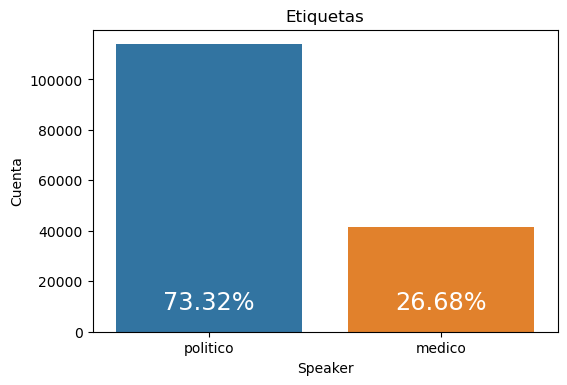

In [4]:
fig = plt.figure(dpi=100)
ax = fig.gca()
sns.countplot(x='speaker', data=dialogs, ax=ax)
ax.set_title("Etiquetas")
ax.set_xlabel("Speaker")
ax.set_ylabel("Cuenta")

percentages = (dialogs["speaker"].value_counts() / len(dialogs)).to_dict()
xs = {label.get_text():idx for idx, label in enumerate(ax.get_xticklabels())}
for label, pct in percentages.items():
#    x = labels[label].get_x()
    ax.text(xs[label],9000, f"{pct:0.2%}", ha='center', fontsize="xx-large", c="white")
    pass

### Longitud del texto

In [5]:
lengths = dialogs["dialog"].str.len()

dialog_lenghts = pd.DataFrame({
    "speaker": dialogs["speaker"],
    "length": lengths
})

<AxesSubplot:xlabel='length', ylabel='speaker'>

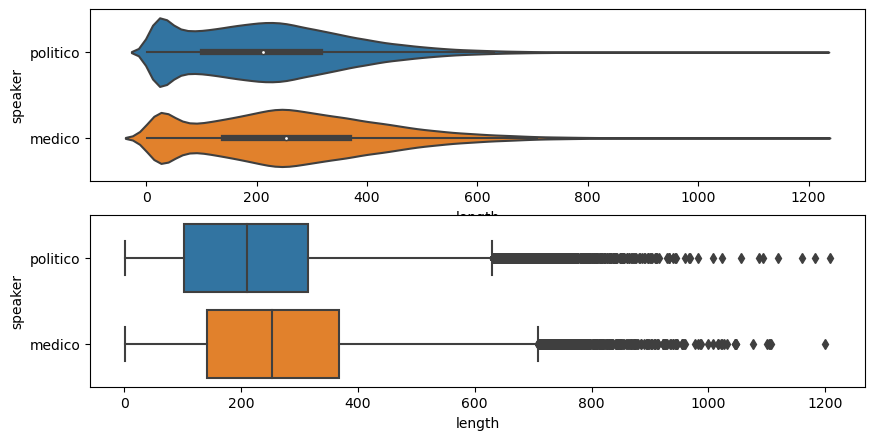

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=100, figsize=(10,5))

sns.violinplot(y="speaker" , x="length", data=dialog_lenghts, ax=ax1)
sns.boxplot(y="speaker" , x="length", data=dialog_lenghts, ax=ax2)

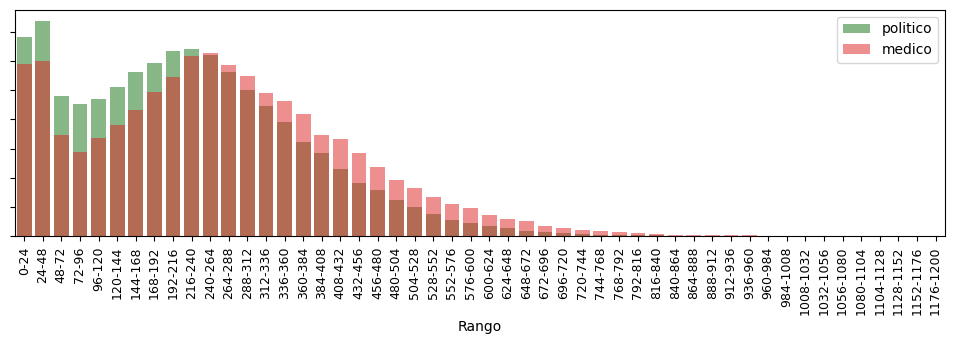

In [7]:
fig = plt.figure(dpi=100, figsize=(12, 3))
ax = fig.gca()


for label, color in [("politico", "green"), ("medico", "red")]:
    lengths = dialog_lenghts[dialog_lenghts["speaker"] == label]
    values, bins = np.histogram(lengths["length"], range=(0, 1200), bins=50)
    y = (bins[1:] + bins[:-1]) / 2
    sns.barplot(x=y, y=values/ len(lengths), label=label, color= color, ax=ax, alpha=0.5 )
ax.set_xticklabels([f"{int(_y)}-{int(_x)}" for _x,_y in zip(bins[1:], bins[:-1])], rotation=90, fontsize=9)
ax.set_yticklabels([])
ax.set_xlabel("Rango")
ax.legend()

 > 💡 Parece que hay dos distribuciones. ¿Mi intuición me dice que cuando son diálogos cortos, es muy probable que esos diálogos se parezcan? ¿Podríamos tal vez dividir los datos y crear modelos diferentes? 

## Divide el dataset

La primer tarea que tienen que hacer una vez que concluyeron con el análisis exploratorio inicial es dividir su dataset en un conjunto de datos, idealmente en tres conjuntos de datos como ya lo habíamos mencionado antes: uno de entrenamiento, otro de validación y uno de prueba.

Para esto vamos a usar `scikit-learn`:

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
largos = dialogs[dialogs['length'] > 240]
largos

,speaker,dialog,length
2,politico,"Antes de entrar en materia, quiero enviar un s...",471
3,politico,Di la instrucción de que se mantengan trabajan...,338
8,politico,"Voy a regresar a Chiapas, a Tabasco en una sem...",363
9,politico,Son inercias que quedaron desde que se privile...,457
12,politico,"Vamos a estar viniendo, le tomo la palabra al ...",247
...,...,...,...
155487,politico,Pero estoy informado porque la misma gente me ...,283
155488,politico,Vamos a destinar recursos para mejorar las uni...,247
155490,politico,Hoy en el acuerdo que tuvimos con el general s...,450
155492,politico,¿Saben dónde nació el actual Ejército? En Coah...,270


In [10]:
rest, test = train_test_split(largos, test_size=0.2, stratify=largos["speaker"])
train, val = train_test_split(rest, test_size=0.2, stratify=rest["speaker"])
len(train), len(val), len(test)

(44900, 11226, 14032)

Es hora de ir separando nuestras variables de salida, el resultado esperado del resto de nuestros datos.

 > 💡 Debes mantener siempre esta separación porque de otro modo puedes "contaminar" tus resultados, incurriendo en un fenómeno conocido como *data leakage*

In [11]:
dialogs_train = train["dialog"]
dialogs_val = val["dialog"]
dialogs_test = test["dialog"]

target_train = train["speaker"]
target_val = val["speaker"]
target_test = test["speaker"]

## Feature engineering

### Etiqueta

Nuevamente, los algoritmos de *machine learning* requieren de datos de tipo numérico para trabajar, el primer valor que tenemos que tenemos que transformar es la etiqueta final. Lo que vamos a hacer es transformar estos valores en `1` si se trata de la cadena "amlo" y `0` si se trata de "lopez-gatell":

In [12]:
train_y = np.where(target_train == "politico", 1, 0)
val_y = np.where(target_val == "politico", 1, 0)
test_y = np.where(target_test == "politico", 1, 0)

### Texto

Toca ahora comenzar por convertir nuestro texto a algo que un modelo de machine learning comprenda, como les mencioné, los modelos de machine learning funcionan, en su gran mayoría, únicamente con datos de tipo numérico, ya sea flotantes o entero. Y bueno, en nuestro caso tenemos una variable de tipo cadena, nuestro diálogo. Ahora, aquí hay varios caminos que podemos tomar para convertir un texto a números, a este proceso le vamos a conocer como vectorización...

 > 💡 El análisis de texto y procesamiento de lenguaje natural es un campo por si mismo, este es solo una pequeña introducción al tema

#### Limpieza de las cadenas

Justo antes de comenzar a tratar de convertir cadenas en números, vamos a echarle un vistazo nuevamente a algunos ejemplos de texto:

In [13]:
dialogs_train.sample(10, random_state=132).values

array(['Ahora, aprovecho para aclararlo en términos generales. En primer lugar, el gobierno no ha firmado ningún convenio para la atención de COVID con hospitales privados. El convenio que se firmó es para la atención, son seis condiciones clínicas o seis procedimientos, no voy a recordar en este momento cada uno de ellos, pero incluye la atención del parto y el puerperio, la realización de hemodiálisis, la atención de úlceras sangrantes, la colecistitis aguda, es la inflamación de la vesícula, que requiere un procedimiento quirúrgico, y no recuerdo las otras dos.',
       'Pues yo lo que creo, que este tema lo debe resolver el tribunal electoral para que se resuelva adecuadamente, en el marco de la legalidad. No voy a juzgar, sólo decir que existe una estrategia política en contra nuestra para que el movimiento de transformación no tenga mayoría en la Cámara de Diputados.',
       'Y la cuarta atención en materia de salud es la regularización de todo el personal de salud, porque hay 8

Escojamos una frase como ejemplo:

In [14]:
dialogs_train.sample(5)

10401    ‘Décimo quinto. La presente petición no contra...
58536    Pero también puede ocurrir, a pesar de que lle...
24555    Porque antes se celebraba, se le aplaudía al c...
70380    Entonces, tenemos muchísimos centros de salud,...
73582    Nosotros no queremos muertos, no queremos la g...
Name: dialog, dtype: object

In [15]:
example_sentence = dialogs_train.iloc[33390]
print(example_sentence)

Eso es todo. Vamos hacia adelante, tengamos mucha fe, van a mejorar las cosas. Y, repito, no voy a traicionar al pueblo, no les voy a fallar, vamos entre todos a hacer historia, a llevar a cabo la Cuarta Transformación de la vida pública de México.


#### Tokenización

Para comenzar con la vectorización vamos a separar cada una de nuestras oraciones en *tokens*, un *token* no necesariamente es una palabra como la conocemos en español, un token puede ser parte de una palabra, puede ser un par de palabras combinadas o inclusive un símbolo de puntuación.

Podríamos hacer algo tan simple y sencillo como separar las oraciones en los espacios en blanco usando `split`, y mientras que esto funciona, podemos hacer algo mucho mejor si usamos una herramienta muy popular en el mundo de Python y el procesamiento de lenguaje natural. Esta herramienta se llama **NLTK** (*Natural Language ToolKit*).

In [16]:
from nltk.tokenize.toktok import ToktokTokenizer

tk_tokenizer = ToktokTokenizer()

In [17]:
tokens = tk_tokenizer.tokenize(example_sentence)
print(" # ".join(tokens))

Eso # es # todo. # Vamos # hacia # adelante # , # tengamos # mucha # fe # , # van # a # mejorar # las # cosas. # Y # , # repito # , # no # voy # a # traicionar # al # pueblo # , # no # les # voy # a # fallar # , # vamos # entre # todos # a # hacer # historia # , # a # llevar # a # cabo # la # Cuarta # Transformación # de # la # vida # pública # de # México # .


Vamos a ver qué encontramos entre los tokens:

 - **Símbolos de puntuación**: Lo que me interesa en esta etapa son las palabras, no tanto los símbolos de puntuación puesto que estamos hablando de un modelo sencillo, además de que los símbolos de puntuación no son indicativos de cómo es que habla una persona necesariamente, sino que estos son artefactos que las personas que transcribieron las conferencias usan para hacer más entendible el diálogo. Así que vamos a eliminarlos
 
 - **Stopwords**: el español, así como otros idiomas, contiene palabras que son usadas por todos y todas las hablantes, independientemente del tema del que estemos hablando, palabras como: él, la, al, a, que, los... forman parte del vocabulario de todos, así que también podemos descartarlas puesto que si todas las usan, no van a ser tan indicativas o específicas para determinada persona.
 
 - **Números**: otra cosa que podemos hacer es convertir tokens de una sola categoría pero que no necesariamente son los mismos siempre, por ejemplo números, si una persona se la pasa hablando constantemente de cifras esto puede ser indicativo de que esa persona se dedica a determinada profesión. Podemos también convertir cualquier número como 50, 30, 1 a algo normalizado y conocido, por ejemplo: `<NUM>`
 
 - **Palabras con tildes** (opcional): en español tiene usamos tildes para darle significado a ciertas palabras, sin embargo por el momento vamos a eliminar los acentos para simplificar un poco más el modelo. Si vemos que el desempeño es muy pobre podríamos considerar acentos y tildes.
 
Nosotros vamos a crear una función que nos permita convertir una frase en tokens, a la vez que nos ayude a eliminar las tildes, los símbolos de puntuación y las stopwords:

In [18]:
sp_stopwords = stopwords.words("spanish")
sp_punctuation = string.punctuation + '¿¡'

not_wanted = set((unidecode(word) for word in sp_stopwords)) | set(sp_punctuation)

tk_tokenizer = ToktokTokenizer()


def tokenize(sentence):
    clean = []
    clean_sentence = unidecode(sentence)
    for token_ in tk_tokenizer.tokenize(clean_sentence):
        token = token_.lower()
        if token in not_wanted:
            continue
        clean.append(token)
    return clean

In [19]:
tokens = tokenize(example_sentence)
print(example_sentence)
print()
tokens = tokenize(example_sentence)
print(" # ".join(tokens))

Eso es todo. Vamos hacia adelante, tengamos mucha fe, van a mejorar las cosas. Y, repito, no voy a traicionar al pueblo, no les voy a fallar, vamos entre todos a hacer historia, a llevar a cabo la Cuarta Transformación de la vida pública de México.

todo. # vamos # hacia # adelante # mucha # fe # van # mejorar # cosas. # repito # voy # traicionar # pueblo # voy # fallar # vamos # hacer # historia # llevar # cabo # cuarta # transformacion # vida # publica # mexico


#### One-hot encoding

El siguiente paso es convertir esa secuencia de tokens limpios a un conjunto de números. Para esto existen todavía más opciones, pero vamos nuevamente a comenzar con una más sencilla. Digamos que vamos a crear una tabla enorme en donde las columnas serán todos y cada uno de los tokens y cada una de las filas va a ser cada uno de los ejemplos que tenemos a nuestro alcance.

Entonces, lo que vamos a hacer es ir oración por oración y token por token, cuando encontremos un token en una oración vamos a poner un `1` en esa fila y en esa columna, podemos verlo con un ejemplo.

Tokens
 1. viva mexico paisanos septiembre
 2. mexico inundaciones viva voz
 
Obtendríamos algo como esto:
 
|       | viva | mexico | paisanos | ... | septiembre | inundaciones | voz |
|-------|------|--------|----------|-----|------------|--------------|-----|
| **1** | 1    | 1      | 1        | ... | 1          | 0            | 0   |
| **2** | 1    | 1      | 0        | ... | 0          | 1            | 1   |


Podríamos implementar esto manualmente, pero también, la mejor opción es usar algo que ya alguien más ha implementado:

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizador_ejemplo = CountVectorizer(binary=True, analyzer=tokenize, max_features=4000)

In [21]:
ejemplos = [
    "viva mexico paisanos en setpiembre. en mexico hay inundaciones de viva voz Hay el acuerdo con algunas empresas, comercios, que la ropa que se decomisa, se quema para no generar competencia desleal Durante mucho tiempo se creó esta forma de actuar en el gobierno, de llevar a cabo decomisos en aduanas y almacenar, y se tienen muchísimas bodegas y se paga renta, y se echan a perder las cosas, se roban muchos bienes",
    "en mexico hay inundaciones de viva voz Durante mucho tiempo se creó esta forma de actuar en el gobierno, de llevar a cabo decomisos en aduanas y almacenar, y se tienen muchísimas bodegas y se paga renta, y se echan a perder las cosas, se roban muchos bienes"
]
vectors = vectorizador_ejemplo.fit_transform(ejemplos)

vocabulary = vectorizador_ejemplo.vocabulary_
columns = [token for token, _ in sorted(vocabulary.items(), key=lambda item: item[1])]
pd.DataFrame(vectors.todense(), columns=columns, index=[1, 2])

,actuar,acuerdo,aduanas,almacenar,bienes,bodegas,cabo,comercios,competencia,cosas,...,paisanos,perder,quema,renta,roban,ropa,setpiembre.,tiempo,viva,voz
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,0,1,1,1,1,1,0,0,1,...,0,1,0,1,1,0,0,1,1,1


Ahora si, vamos a crear este vectorizador final que vamos a usar en nuestro modelo final.

In [22]:
vectorizador_real = CountVectorizer(binary=True, analyzer=tokenize, max_features=1000)

Vamos a "entrenar" nuestro vectorizador usando nuestros datos de entrenamiento, luego vamos a transformar el conjunto de validación y el conjunto de prueba.

 > ¡Recuerda que NO debemos entrenar nada con los conjuntos de validación y prueba!

In [23]:
vectorizador_real.fit(dialogs_train)

train_x = vectorizador_real.transform(dialogs_train)
val_x = vectorizador_real.transform(dialogs_val)
test_x = vectorizador_real.transform(dialogs_test)

## Modelado

Al tratarse de un problema de clasificación, podemos hacer uso de modelos como el de la regresión lineal, una máquina de soporte de vectores o inclusive el de bosques aleatorios.

Para este ejercicio voy a usar una regresión logística:

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
lr = LogisticRegression(max_iter=1000, class_weight="balanced")

In [26]:
lr.fit(train_x, train_y)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [27]:
train_pred = lr.predict(train_x)  # Para diagnosticar overfitting
val_pred = lr.predict(val_x)  # Para decidir cambios sobre el modelo

### Revisando las métricas establecidas

In [28]:
from sklearn.metrics import accuracy_score

In [29]:
training_accuracy = accuracy_score(train_y, train_pred)
validation_accuracy = accuracy_score(val_y, val_pred)

print(f"Training accuracy:   {training_accuracy:0.2%}")
print(f"Validation accuracy: {validation_accuracy:0.2%}")

Training accuracy:   96.85%
Validation accuracy: 96.21%


### Evaluando el desempeño en el conjunto de prueba

Una vez que estamos contentos con el modelo creado, podemos ponerlo a prueba en el conjunto de datos de *test* para verificar la calidad de nuestro modelo.

In [30]:
test_pred = lr.predict(test_x)
test_accuracy = accuracy_score(test_y, test_pred)

print(f"Test accuracy:   {test_accuracy:0.2%}")

Test accuracy:   95.85%


## Evaluando en una oración propia

In [31]:
#oración = "Quedate en casa, la curva epidémica no se ha reducido. Si tienes fiebre mejor que te quedes en la casa. Hay que cuidarse y no bajar la guardia. Todos juntos podemos evitar el colapso de los hospitales"

#oracion = "Nos encontramos de nuevo en este foro global que ha sido históricamente un espacio vital para el desarrollo del multilateralismo, la construcción global de la paz y de soluciones a las amenazas de nuestra casa común. Lo hacemos aun en medio de una pandemia cruel que golpea nuestros sistemas de salud, nuestras economías, nuestras conquistas de equidad y el avance de la Agenda 2030"
#oracion = "Por encima de cualquier consideración, nos encontramos una vez más, en este histórico hemiciclo recordando la fragilidad del ser humano y, al mismo tiempo, reconociendo la grandeza y la condición de una raza humana que sabe sobreponerse a los grandes desafíos.El covid-19 irrumpió de manera abrupta en nuestras vidas. Cambió nuestra cotidianidad, nuestra interacción y nos arrebató seres queridos. Este virus letal ha puesto a prueba nuestras emociones para entender, HOY MÁS QUE NUNCA, cuánto vale el abrazo de un padre y el de una madre, cuánto significa compartir en familia, cuánto nos llena un encuentro amigable inesperado."
oracion = "el esquema de la devolución del impuesto de IVA para más de dos millones de hogares vulnerables"

own_x = vectorizador_real.transform([oracion])
result = lr.predict(own_x)
medico, politico = lr.predict_proba(own_x).squeeze() * 100
print(f"{medico:05.2f}% – Médico\n{politico:05.2f} - Político")

20.34% – Médico
79.66 - Político


## De tarea... 

 - ¿Recuerdas la distribución de la longitud de cada diálogo? explora un poco más el dataset para corroborar si es buena idea trabajar con un solo modelo.
 - Prueba con diversas maneras de vectorizar el texto:
     - Tokeniza las palabras de diversas maneras.
     - Revisa los parámetros de `CountVectorizer`.
     - Investiga y revisa si `TfidfVectorizer` es mejor.
 - Intenta crear diversos modelos con diversos algoritmos.

## Para aprender más  

 - Revisa cómo creo el dataset en [GitLab](https://gitlab.com/thatcsharpguy/datasets/mananeras)
 - Revisa el libro [Applied Text Analysis with Python](https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/)
 - Lee mi serie sobre Análisis de Texto en [Tacos de Datos](https://www.tacosdedatos.com/ioexception/introduccion-al-analisis-de-texto-4247)
 - Hay otras bibliotecas específicas para trabajar con texto: [Gensim](https://radimrehurek.com/gensim/), [spaCy](https://spacy.io/) y [Hugging Face](https://huggingface.co)
